In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
from PIL import Image
import cv2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                transforms.Resize(224), 
                                transforms.CenterCrop(224),
                                transforms.Grayscale()])

In [64]:
dataset = datasets.ImageFolder("archive (1)\Brain Tumor Data Set\Brain Tumor Data Set", transform=transform)
class_name = dataset.classes

In [65]:
train_size = int(0.7*(len(dataset)))
test_size = int(0.3*(len(dataset)))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [201]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=10)

Label: [0 0 0 0 0 1 0 0 1 1]
Class: Brain Tumor Brain Tumor Brain Tumor Brain Tumor Brain Tumor Healthy Brain Tumor Brain Tumor Healthy Healthy


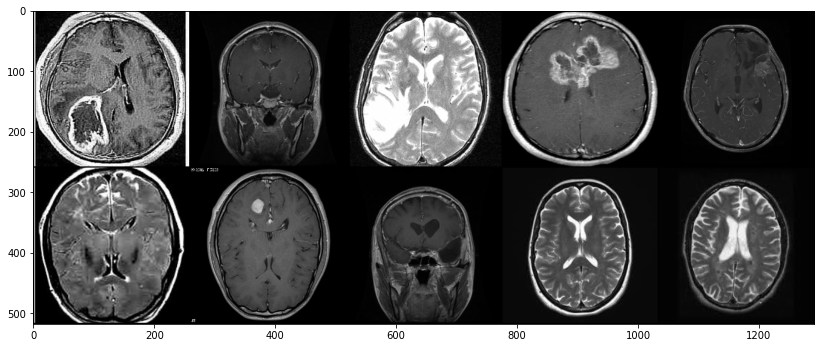

In [67]:
for image, label in train_loader:
    break

print('Label:', label.numpy())
print('Class:', *np.array([class_name[i] for i in label]))

# the default nrow is 8
im = make_grid(image, nrow=5)  

# Print the images
plt.figure(figsize=(14,6))
plt.imshow(np.transpose(im, (1, 2, 0)))

In [184]:
conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=3)
conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=3)
dropout = nn.Dropout(0.3)
fc1 = nn.Linear(7*7*64, 120)
fc2 = nn.Linear(120, 2)

In [185]:
for i , (X_train,Y_train) in enumerate(train_loader):
    break

In [186]:
X_train.shape

torch.Size([10, 1, 256, 256])

In [187]:
X = F.relu(conv1(X_train))
X = dropout(X)
X = F.max_pool2d(X, 2, 2)
X = F.relu(conv2(X))
X = dropout(X)
X = F.max_pool2d(X, 2, 2)
# X = F.relu(conv3(X))
# X = dropout(X)
# X = F.max_pool2d(X, 2, 2)
# X = F.relu(conv4(X))
# X = dropout(X)
# X = F.max_pool2d(X, 2, 2)


In [188]:
X.shape

torch.Size([10, 32, 7, 7])

In [189]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=3)
        self.fc1 = nn.Linear(7*7*32, 120)
        self.fc2 = nn.Linear(120, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        # X = F.relu(self.conv3(X))
        # X = self.dropout(X)
        # X = F.max_pool2d(X, 2, 2)
        # X = F.relu(self.conv4(X))
        # X = self.dropout(X)
        # X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 32*7*7)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return F.log_softmax(X, dim=1)

In [190]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [191]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

   144
    16
  4608
    32
188160
   120
   240
     2
______
193322


In [192]:
len(train_loader)

322

In [193]:
len(test_loader)

138

In [194]:
epoch = 8
losses = []
train_losses = []
train_correct = []

for i in range(epoch):
    trn_corr = 0
    tst_corr = 0

    for b,(x_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(x_train)
        loss = criterion(y_pred,y_train)
     
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%64 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/3200]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

epoch:  0  batch:   64 [   640/3200]  loss: 0.60889357 accuracy:  57.500%
epoch:  0  batch:  128 [  1280/3200]  loss: 0.60579067 accuracy:  60.391%
epoch:  0  batch:  192 [  1920/3200]  loss: 0.65564358 accuracy:  62.240%
epoch:  0  batch:  256 [  2560/3200]  loss: 0.57996309 accuracy:  64.141%
epoch:  0  batch:  320 [  3200/3200]  loss: 0.44767207 accuracy:  66.156%
epoch:  1  batch:   64 [   640/3200]  loss: 0.37212163 accuracy:  78.125%
epoch:  1  batch:  128 [  1280/3200]  loss: 0.47539416 accuracy:  79.375%
epoch:  1  batch:  192 [  1920/3200]  loss: 0.47835249 accuracy:  78.594%
epoch:  1  batch:  256 [  2560/3200]  loss: 0.47097626 accuracy:  78.789%
epoch:  1  batch:  320 [  3200/3200]  loss: 0.70431322 accuracy:  79.312%
epoch:  2  batch:   64 [   640/3200]  loss: 0.30164382 accuracy:  84.531%
epoch:  2  batch:  128 [  1280/3200]  loss: 0.41683778 accuracy:  84.531%
epoch:  2  batch:  192 [  1920/3200]  loss: 0.57993758 accuracy:  84.635%
epoch:  2  batch:  256 [  2560/3200]  

In [203]:
with torch.no_grad():
    for ind ,(x_test, y_test) in enumerate(test_loader):
        y_pred = model(x_test)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_test).sum()
    print(batch_corr.item()*100/len(test_loader)*10)

65.21739130434783
